Reference: https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
X_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) # np.prod: Return the product of array elements over a given axis. 60000, 28, 28 to 60000, 784
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [4]:
X_train = tf.reshape(X_train, shape=(X_train.shape[0], 28, 28))
X_test = tf.reshape(X_test, shape=(X_test.shape[0], 28, 28))

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
INPUT_SHAPE = (28,28,1)
LATENT_DIM = 50
# Training loop
EPOCHS = 20
BATCH_SIZE = 64

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 28, 28, 1), dtype=tf.float32, name=None)>

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None)>

In [33]:
# Encoder Model
def create_encoder_model(input_shape, latent_dim, kernel_size=3):
    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding="same", activation="relu")(input)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=(2,2), activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=kernel_size, strides=(2,2), activation="relu", padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(latent_dim, name='output')(x)
    return tf.keras.Model(input, output, name='encoder')

encoder = create_encoder_model(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM,
                             kernel_size=3)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                401472    
                                                                 
 output (Dense)              (None, 50)                3250

In [34]:
# Decoder Model
def create_decoder_model(latent_dim, kernel_size=3):
    input = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(128, activation='relu')(input)
    x = tf.keras.layers.Dense(7 * 7 * 128, activation='relu')(x)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
    output = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
    return tf.keras.Model(input, output, name='decoder')

decoder = create_decoder_model(latent_dim=LATENT_DIM,
                             kernel_size=3)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_7 (Dense)             (None, 128)               6528      
                                                                 
 dense_8 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 32)        36896     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 64)        18496     
 Transpose)                                                

In [35]:
# Discriminator Model
def create_discriminator_model(latent_dim):
    input = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(input)
    x = tf.keras.layers.Dense(32, activation='relu')(input)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(input, output, name='discriminator')

discriminator = create_discriminator_model(LATENT_DIM)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_10 (Dense)            (None, 32)                1632      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1665 (6.50 KB)
Trainable params: 1665 (6.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
autoencoder = tf.keras.Sequential([
    encoder,
    decoder
])

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 50)                497394    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         871585    
                                                                 
Total params: 1368979 (5.22 MB)
Trainable params: 1368979 (5.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
def generate_and_save_images(model, input_shape, latent_dim, epoch):
  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
      rnd_normal_noise = np.random.normal(0, 1, (1, latent_dim))
      img = model.predict(rnd_normal_noise)
      img = img.reshape((input_shape[0], input_shape[1]))
      plt.subplot(4, 4, i+1)

      #plt.imshow(img[i, :, :, 0] * 255)  # denormalize - for rgb images
      plt.imshow(img, cmap="gray")
      plt.axis('off')   # No axis, show only image

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [38]:
# Adversarial model
# discriminator.trainable = False
'''
Setting the trainable property of the discriminator model to False
during the training of the adversarial autoencoder is a technique
used in adversarial training to decouple the training of the generator
(or encoder in this case) from the discriminator. This is commonly
done in a GAN (Generative Adversarial Network) setup. By setting
trainable=False for the discriminator when training the generator,
you essentially freeze the weights of the discriminator during the
generator's backpropagation step. This ensures that the generator is
updated based on the feedback from the discriminator at its current state,
without changing the discriminator's ability to distinguish real and
generated data.
'''
gan_input = tf.keras.Input(shape=INPUT_SHAPE)
encoded_img = encoder(gan_input)
validity = discriminator(encoded_img)
gan = tf.keras.Model(gan_input, validity)

In [39]:
# Compile models
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy())
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.BinaryCrossentropy())
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.BinaryCrossentropy())

In [40]:
@tf.function
def train_step(image_batch):
    # Train Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder.trainable = True
        decoder.trainable = True

        recons_imgs = autoencoder(image_batch, training=True)
        ae_loss = autoencoder.loss(image_batch, recons_imgs)

    ae_gradients = ae_tape.gradient(ae_loss, autoencoder.trainable_variables)
    autoencoder.optimizer.apply_gradients(zip(ae_gradients, autoencoder.trainable_variables))

    # Train discriminator
    with tf.GradientTape() as disc_tape:
        discriminator.trainable = True
        latent_z = encoder(image_batch)
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

        d_real_out = discriminator(latent_z, training=True)
        d_fake_out = discriminator(noise, training=True)

        d_loss_real = discriminator.loss(np.zeros((BATCH_SIZE, 1)), d_real_out)
        d_loss_fake  = discriminator.loss(np.ones((BATCH_SIZE, 1)), d_fake_out)
        d_loss = 0.5 * tf.reduce_sum(tf.add(d_loss_real, d_loss_fake))

    disc_gradients = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Train GAN
    with tf.GradientTape() as gan_tape:
        encoder.trainable = True
        discriminator.trainable = False

        g_real_out = gan(image_batch, training=True)
        g_loss = gan.loss(np.ones((BATCH_SIZE, 1)), g_real_out)

    gan_gradients = gan_tape.gradient(g_loss, gan.trainable_variables)
    gan.optimizer.apply_gradients(zip(gan_gradients, gan.trainable_variables))

    return ae_loss, d_loss, g_loss

In [41]:
from IPython import display
import time

def train(dataset, epochs):
    ae_loss_hist = []
    d_loss_hist = []
    g_loss_hist = []

    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            ae_loss, d_loss, g_loss = train_step(image_batch)

        stop = time.time()

        ae_loss_hist.append(ae_loss)
        d_loss_hist.append(d_loss)
        g_loss_hist.append(g_loss)

        print(f"ae_loss: {tf.reduce_mean(ae_loss).numpy()},  disc_loss: {tf.reduce_mean(d_loss).numpy()},  adversarial_loss: {tf.reduce_mean(g_loss).numpy()}, time: {stop-start}")
        print("Reconstruction Loss:", autoencoder.evaluate(X_train, X_train, verbose=0))
        print("Adverserial Loss:", gan.evaluate(X_train, np.ones(len(X_train)), verbose=0))

        display.clear_output(wait=True)
        generate_and_save_images(decoder, input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM, epoch=epoch)

    return ae_loss_hist, d_loss_hist, g_loss_hist

1/1 [==============================] - 0s 23ms/step


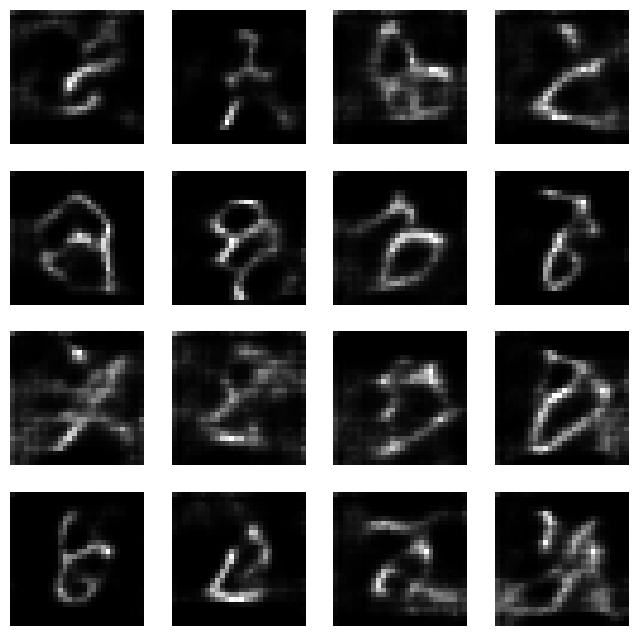

([<tf.Tensor: shape=(), dtype=float32, numpy=0.09911646>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08997915>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08797764>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08277066>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.082851194>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08031232>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.078032814>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.078144826>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.07628641>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.076833926>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.07834008>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0778283>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.076436244>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.077181384>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08019503>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.079926595>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.07724687>,
  <tf.Te

In [42]:
train(train_dataset, EPOCHS)

Alternative way to train AAE model

In [43]:
'''
from IPython import display

# Reference: https://www.kaggle.com/code/ankasor/adversarial-autoencoding-with-keras
for epoch in range(EPOCHS):
    for _ in range(X_train.shape[0] // BATCH_SIZE):
        #idx = tf.random.uniform(
        #      shape=(BATCH_SIZE,),
        #      minval=0,
        #      maxval=X_train.shape[0],
        #      dtype=tf.dtypes.int32,
        #      seed=4,
        #)
        autoencoder.trainable = True
        encoder.trainable = True
        decoder.trainable = True

        # Train Autoencoder
        idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
        idx_tensor = tf.constant(idx, dtype=tf.int32)
        #real_imgs = X_train[idx]
        real_imgs = tf.gather(X_train, idx_tensor)  # tf.gather is used to gather
        # elements from the tensor based on the indices provided in idx_tensor.

        ae_loss = autoencoder.train_on_batch(real_imgs, real_imgs)

        # Train discriminator
        discriminator.trainable = True
        latent_z = encoder.predict(real_imgs)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

        discriminator_input_x = np.concatenate([latent_z, noise])
        discriminator_input_y = np.concatenate([np.zeros(BATCH_SIZE),
                                                np.ones(BATCH_SIZE)])

        d_loss = discriminator.train_on_batch(discriminator_input_x, discriminator_input_y)
        # OR
        # d_loss_real = discriminator.train_on_batch(latent_z, np.ones((BATCH_SIZE, 1)))
        # d_loss_fake = discriminator.train_on_batch(noise, np.zeros((BATCH_SIZE, 1)))
        # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # print(f"Discriminator Loss: {d_loss}"")

        # Train GAN
        gan.trainable = True
        encoder.trainable = True
        discriminator.trainable = False

        g_loss = gan.train_on_batch(real_imgs, np.ones(BATCH_SIZE))
        # g_loss = gan.train_on_batch(real_imgs, np.ones(BATCH_SIZE))
        # print(f"Adversarial Loss: {g_loss}"")

    print ("Reconstruction Loss:", autoencoder.evaluate(X_train, X_train, verbose=0))
    print ("Adverserial Loss:", gan.evaluate(X_train, np.ones(len(X_train)), verbose=0))

    display.clear_output(wait=True)
    generate_and_save_images(decoder, input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM, epoch=epoch)
'''

'\nfrom IPython import display\n\n# Reference: https://www.kaggle.com/code/ankasor/adversarial-autoencoding-with-keras\nfor epoch in range(EPOCHS):\n    for _ in range(X_train.shape[0] // BATCH_SIZE):\n        #idx = tf.random.uniform(\n        #      shape=(BATCH_SIZE,),\n        #      minval=0,\n        #      maxval=X_train.shape[0],\n        #      dtype=tf.dtypes.int32,\n        #      seed=4,\n        #)\n        autoencoder.trainable = True\n        encoder.trainable = True\n        decoder.trainable = True\n\n        # Train Autoencoder\n        idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)\n        idx_tensor = tf.constant(idx, dtype=tf.int32)\n        #real_imgs = X_train[idx]\n        real_imgs = tf.gather(X_train, idx_tensor)  # tf.gather is used to gather\n        # elements from the tensor based on the indices provided in idx_tensor.\n\n        ae_loss = autoencoder.train_on_batch(real_imgs, real_imgs)\n\n        # Train discriminator\n        discriminator.tr